# predicting baseball players salary

In this notebook we we utilize our neural network class to predict a baseball players salary

we will take the following steps
1. EDA - we will import and inspect our data
2. DataPrep - we will make any necessary modifications to our data
3. Modeling -
    4. we will initialize our Neuralnetwork
    5. test the network before training
    6. run a single epoch
    7. test how much that improves performance
    8. run a series of epochs test the final model.


In [1]:
# import os and our neural network
import itertools
import os
import pprint
import sys
module_path= os.path.abspath(os.path.join('..',"python"))

if module_path not in sys.path:
    sys.path.append(module_path)

from neural_net import NeuralNetwork
#import packages for data frames
import numpy as np
import pandas as pd
from patsy import dmatrices

#import pyplot and seaborn for graph creating
import matplotlib.pyplot as plt
import seaborn as sns

#EDA support
import sweetviz as sv

#sklearn support
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

## 1. EDA

In [2]:
data = os.path.join('..','data','Hitters Dataset Clean.csv')
df = pd.read_csv(data)
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
1,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
2,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
3,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
4,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64

running a sweet viz eda

In [4]:
# Analyzing data
# report=sv.analyze(df,target_feat='Salary' )

In [5]:
# Generating repor
# report.show_notebook(w=1000)

**correlation plots**


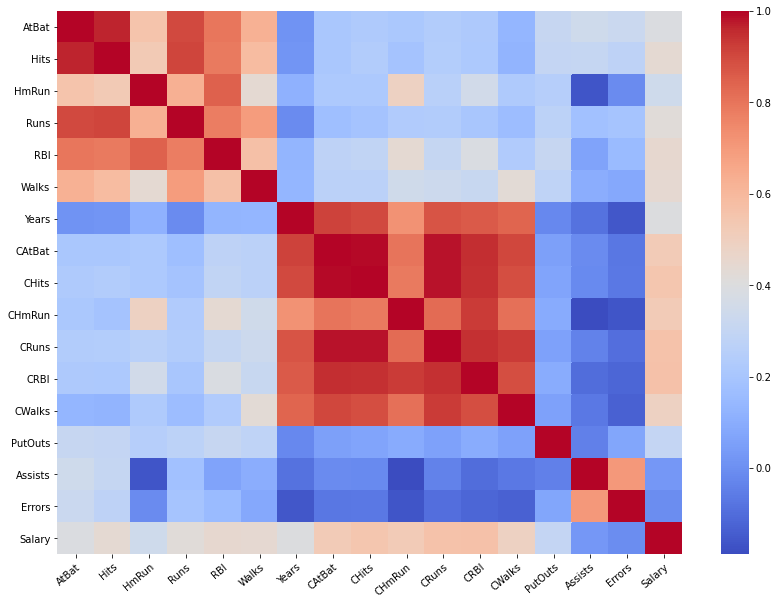

In [6]:
plt.figure(figsize=(14,10))
sns.heatmap(df.select_dtypes(exclude=['object']).corr(),cmap='coolwarm',annot=False)
plt.xticks(rotation=40 , rotation_mode='anchor',ha="right");

**conclusions:**
General:
None of or records are missing any values.

target:
- our target value "Salary" is right skewed which intuitively makes sense very one can't be a super star
- all of of our numerical values have a positive correlation to salary but none have a strong correlation

numerical predictors:
- we will standardize all of these predictors

categorical:
- are categorical are well distributed
- we will dummy them for use in modeling

## 2. Data prep

In [7]:
formula ="Salary ~ -1"
for num in df.select_dtypes(exclude=['object']):
    formula += f' + scale({num})'
for ob in df.select_dtypes(include=['object']):
    formula += f' + C({ob})'

print(formula)

Salary ~ -1 + scale(AtBat) + scale(Hits) + scale(HmRun) + scale(Runs) + scale(RBI) + scale(Walks) + scale(Years) + scale(CAtBat) + scale(CHits) + scale(CHmRun) + scale(CRuns) + scale(CRBI) + scale(CWalks) + scale(PutOuts) + scale(Assists) + scale(Errors) + scale(Salary) + C(League) + C(Division) + C(NewLeague)


In [8]:
y, X = dmatrices(formula,data=df)
X

DesignMatrix with shape (263, 21)
  Columns:
    ['C(League)[A]',
     'C(League)[N]',
     'C(Division)[T.W]',
     'C(NewLeague)[T.N]',
     'scale(AtBat)',
     'scale(Hits)',
     'scale(HmRun)',
     'scale(Runs)',
     'scale(RBI)',
     'scale(Walks)',
     'scale(Years)',
     'scale(CAtBat)',
     'scale(CHits)',
     'scale(CHmRun)',
     'scale(CRuns)',
     'scale(CRBI)',
     'scale(CWalks)',
     'scale(PutOuts)',
     'scale(Assists)',
     'scale(Errors)',
     'scale(Salary)']
  Terms:
    'C(League)' (columns 0:2)
    'C(Division)' (column 2)
    'C(NewLeague)' (column 3)
    'scale(AtBat)' (column 4)
    'scale(Hits)' (column 5)
    'scale(HmRun)' (column 6)
    'scale(Runs)' (column 7)
    'scale(RBI)' (column 8)
    'scale(Walks)' (column 9)
    'scale(Years)' (column 10)
    'scale(CAtBat)' (column 11)
    'scale(CHits)' (column 12)
    'scale(CHmRun)' (column 13)
    'scale(CRuns)' (column 14)
    'scale(CRBI)' (column 15)
    'scale(CWalks)' (column 16)
    'sca

X = np.asarray(X)
y = np.asarray(y)

## 3. model building

we will take the following steps
1. split data <- we will split 
2. substantiate model <- we will initialize our model
3. predict <- we will get the base  error rate
4. train <- we will do an initial run of 30 stochastic epochs

In [9]:
# creating our test train split 
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [10]:
print(X_train[:5])

[[ 1.          0.          1.          0.          0.97504214  0.64767886
  -1.10060456  0.12768136 -0.17367754 -1.34310256 -1.11020876 -0.70963161
  -0.69738782 -0.80739401 -0.70248878 -0.77588367 -0.89646415 -0.10633796
   2.34964766  2.03318767 -0.80159397]
 [ 0.          1.          0.          1.         -0.71172413 -0.72889198
  -0.64296187 -0.65690268 -1.10270522 -0.69724862 -0.90120024 -0.91031237
  -0.86895784 -0.74644899 -0.87794419 -0.92150617 -0.8205782  -0.28171259
  -0.81323757 -0.99987165 -0.8793268 ]
 [ 0.          1.          0.          1.          1.22669679  1.11393673
   0.38673417  0.59843178  1.25857346  0.04087017 -0.4831832  -0.13125036
  -0.13321611 -0.13699883 -0.29107609 -0.0446728  -0.4790914   0.14419722
  -0.68202618 -0.69656571  0.28111326]
 [ 0.          1.          0.          1.         -0.15400302  0.04820446
  -0.29972986  0.24536896 -0.25109652 -0.42045407 -0.06516616  0.15662576
   0.17282773 -0.35640089  0.27159127 -0.25226233 -0.35008528 -0.2244

Now that our data is fully prepared we will initialize a model train it for 30 epochs and see the effect on our total error.

In [22]:
#initilizing model 
model = NeuralNetwork(21,15,1, activation='relu',alpha=.1e-06)

#getting error baseline

errors =  [model.predict(X_train,y_train)]
epochs = 0

errors

[array([6.50096001e+09])]

In [23]:
for x in range(1000):

    model.train(X_train,y_train,batchsize=10)
    errors.append(
                model.predict(X_train,y_train)
                )
    epochs += 1
    X_train, y_train = shuffle(X_train, y_train)


one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch


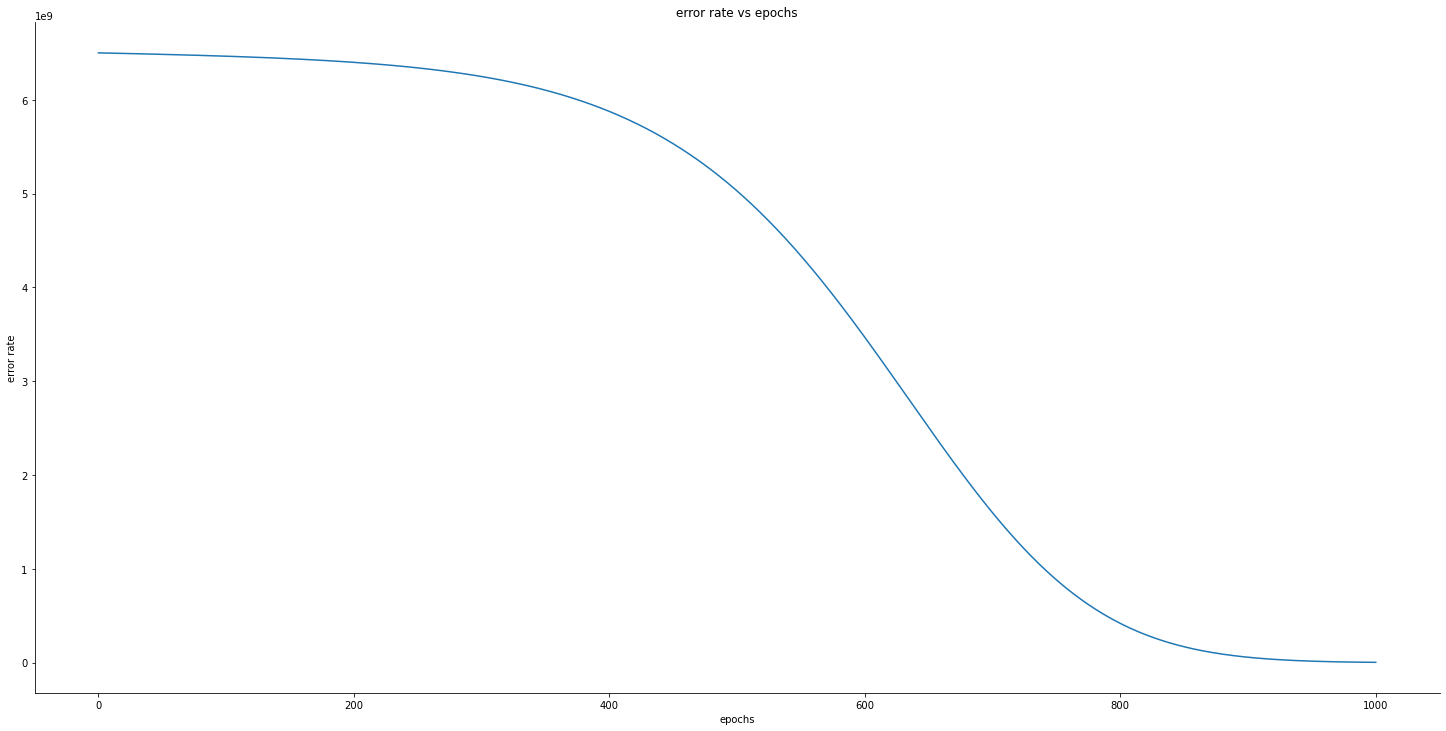

In [24]:
sns.relplot(
            x=list(range(epochs+1)),
            y=[y[0] for y in errors],
            kind="line",
            height=10, aspect=2
).set(title="error rate vs epochs",
      ylabel="error rate",
      xlabel="epochs"

      );

we will run 100 more epochs to see if we have fully flattened our learning curve

In [25]:
for x in range(100):

    model.train(X_train,y_train,batchsize=10)
    errors.append(
        model.predict(X_train,y_train)
    )
    epochs += 1
    X_train, y_train = shuffle(X_train, y_train)


one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch
one batch


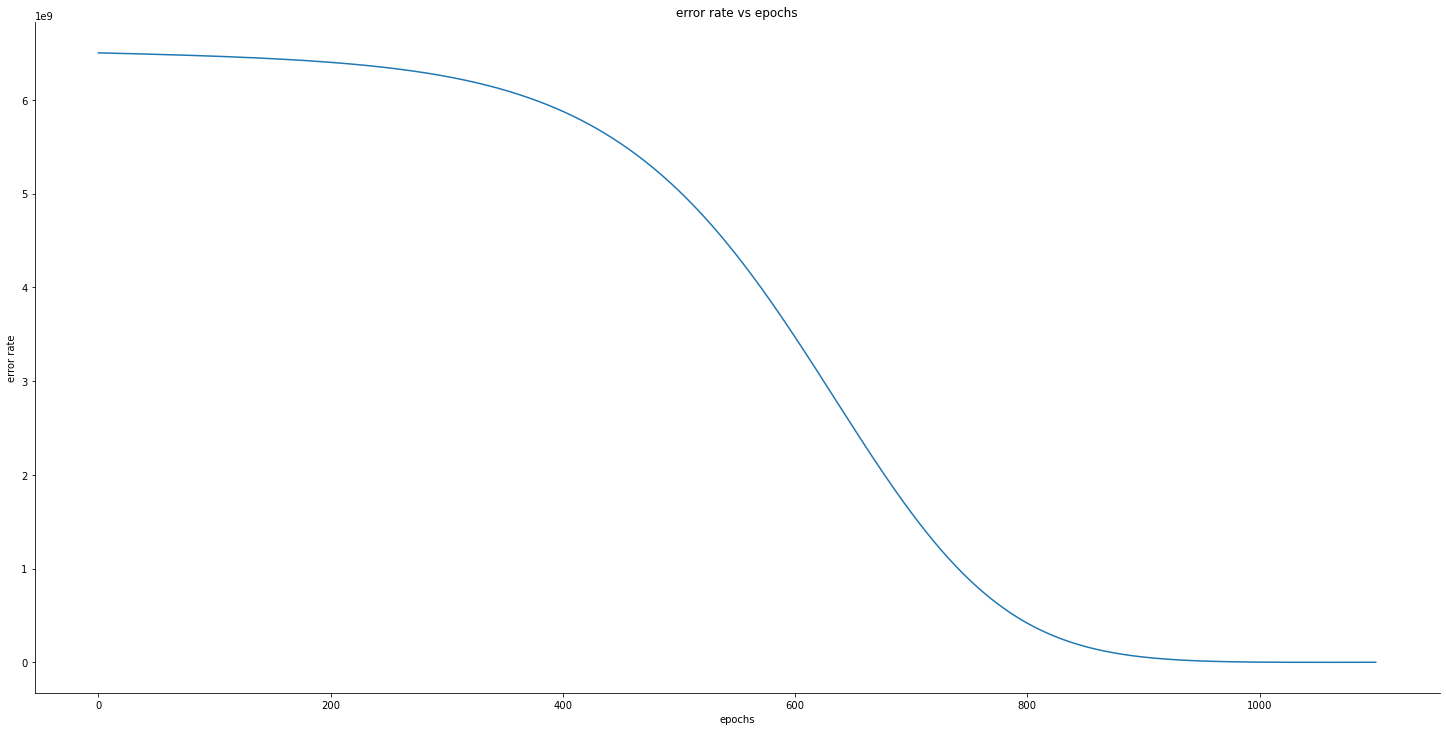

In [26]:
sns.relplot(
            x=list(range(epochs+1)),
            y=[y[0] for y in errors],
            kind="line",
            height=10, aspect=2
).set(title="error rate vs epochs",
      ylabel="error rate",
      xlabel="epochs"

      );

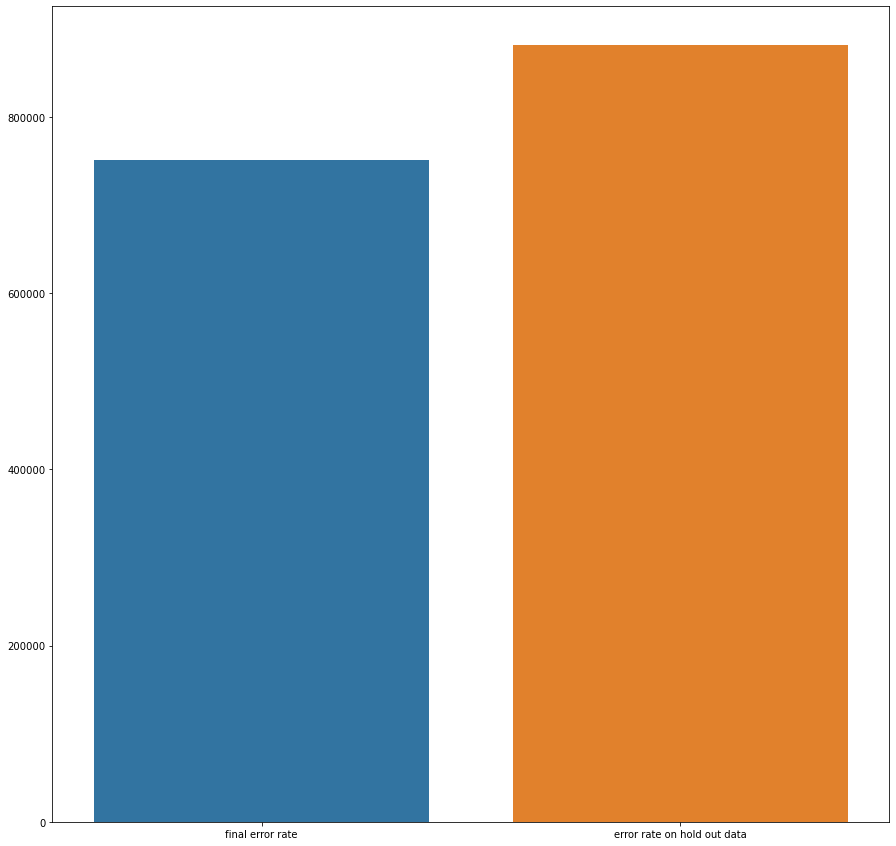

In [33]:
l = ['initial error rate','final error rate','error rate on hold out data']
e =[errors[0][0], errors[-1][0],model.predict(X_test,y_test)[0]];

plt.figure(figsize = (15,15))
sns.barplot( x = l[1:],
             y = e[1:] ,
             );